# CAPSTONE
## Battle of the Neighborhoods
### __Choosing the best place for new Indian Restaurants__
_by Jafar Islamli_

### -----------------------------------------------------------------------------------------------------

#### __Introduction__
This capstone project explores the optimal locations for Indian restaurants throughout the city of New York. 

New York City’s demographics show that it is a large and ethnically diverse metropolis. It is the largest city in the United States with a long history of international immigration. With it’s diverse culture , comes diverse food items. New York is named the best city for diverse asian cuisine. Coming here, you will have a myriad of Asian food options at restaurants or mobile food trucks. 

Food Business News stated that worldwide indian food sales were up for the third year in a row with the United Sates holding the largest market.  New York is a major metropolitan area with more than 8.4 million (Quick Facts, 2018) people living within city limits. Most of the Indian immigration into the United States occurred during the late 19th and early 20th century with over 10 million immigrants between 1950 and 2000s. the need to find and enjoy Indian cuisine is on the rise. 

This report explores which neighborhoods and boroughs of New York City have the most as well as the best Indian restaurants. Additionally, I will attempt to answer the questions “Where should I open an Indian Restaurant?” and “Where should I stay If I want great Indian food?”

### __Data__
In order to answer the above questions, data on New York City neighborhoods, boroughs to include boundaries, latitude, longitude, restaurants, and restaurant ratings and tips are required.

New York City data containing the neighborhoods and boroughs, latitudes, and longitudes will be obtained from the data source: https://cocl.us/new_york_dataset

New York City data containing neighborhood boundaries will be obtained from the data source: https://data.cityofnewyork.us/City-Government/Borough-Boundaries/tqmj-j8zm

All data related to locations and quality of Indian restaurants will be obtained via the FourSquare API utilized via the Request library in Python.

### __Methodology__
•	Data will be collected from https://cocl.us/new_york_dataset and cleaned and processed into a dataframe.

•	FourSquare be used to locate all venues and then filtered by Indian restaurants.  Ratings, tips, and likes by users will be counted and added to the dataframe.

•	Data will be sorted based on rankings

•	Finally, the data be will be visually assessed using graphing from various Python libraries.

### __Problem Statement__
1.	What is / are the best location(s) for Indian cuisine in New York City?
2.	In what Neighborhood and/or borough should I open an Indian restaurant to have the best chance of being successful?
3.	Where would I go in New York City to have the best Indian food?

Load Libraries

In [1]:
import numpy as np
import requests
from bs4 import BeautifulSoup
import os
!conda install -c conda-forge folium=0.5.0 --yes
import folium 
!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline
import seaborn as sns

print('Done!')

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    python_abi-3.6             |          1_cp36m           4 KB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    ca-certificates-2020.4.5.2 |       hecda079_0         147 KB  conda-forge
    folium-0.5.0               |             py_0          45 KB  conda-forge
    altair-4.1.0               |             py_1         614 KB  conda-forge
    openssl-1.1.1g             |       h516909a_0         2.1 MB  conda-forge
    certifi-2020.4.5.2         |   py36h9f0ad1d_0         152 KB  conda-forge
    branca-0.4.1               |             py_0          26 KB  conda-forge
    ------------------------------------------------------------
                       

**My Variables**

In [4]:
CLIENT_ID = 'XIWAJGO4DN2TAOZG2HIHK4SJ2WEEJ1YRY5E5VB3TRGORS0FD' # your Foursquare ID
CLIENT_SECRET = 'XY2H0ESYSZRC2OOXLW4ZFPQ52P2PWXELSSGETVV1AZV4CY5G' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: XIWAJGO4DN2TAOZG2HIHK4SJ2WEEJ1YRY5E5VB3TRGORS0FD
CLIENT_SECRET:XY2H0ESYSZRC2OOXLW4ZFPQ52P2PWXELSSGETVV1AZV4CY5G


**Functions that will be used later**

In [5]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="foursquare_agent")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude


def get_venues(lat,lng):
    #set variables
    radius=400
    LIMIT=100
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


def get_venue_details(venue_id):
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    results = requests.get(url).json()
    print(results)
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    return new_york_data

### Now lets use the above codes to get our initial NYC data

In [6]:
import pandas as pd
ny_data = get_new_york_data()
ny_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [7]:
ny_data.shape

(306, 4)

Now that we have our initial data, lets start analyzing it. We can see below that Manhattan has the least number of neighborhoods in all five buroughs.

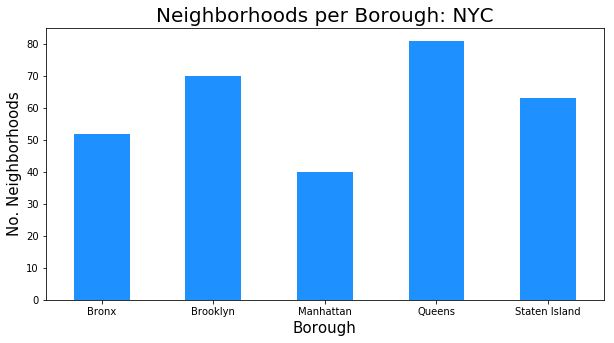

In [8]:
clr = "dodgerblue"
ny_data.groupby('Borough')['Neighborhood'].count().plot.bar(figsize=(10,5), color=clr)
plt.title('Neighborhoods per Borough: NYC', fontsize = 20)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No. Neighborhoods',fontsize = 15)
plt.xticks(rotation = 'horizontal')
plt.show()

Lets analyze further and see how many Indian restaurants there are in each neighborhood and burough and graph the results.

In [9]:
# queens has most neighborhoods
# prepare neighborhood list that contains indian resturants
column_names=['Borough', 'Neighborhood', 'ID','Name']
indian_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in ny_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    indian_resturants=venues[venues['Category']=='Indian Restaurant']   
    print('(',count,'/',len(ny_data),')','Indian Resturants in '+Neighborhood+', '+Borough+':'+str(len(indian_resturants)))
    print(row)
    for resturant_detail in indian_resturants.values.tolist():
        id, name , category=resturant_detail
        indian_rest_ny = indian_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 306 ) Indian Resturants in Wakefield, Bronx:0
['Bronx', 'Wakefield', 40.89470517661, -73.84720052054902]
( 2 / 306 ) Indian Resturants in Co-op City, Bronx:0
['Bronx', 'Co-op City', 40.87429419303012, -73.82993910812398]
( 3 / 306 ) Indian Resturants in Eastchester, Bronx:0
['Bronx', 'Eastchester', 40.887555677350775, -73.82780644716412]
( 4 / 306 ) Indian Resturants in Fieldston, Bronx:0
['Bronx', 'Fieldston', 40.89543742690383, -73.90564259591682]
( 5 / 306 ) Indian Resturants in Riverdale, Bronx:0
['Bronx', 'Riverdale', 40.890834493891305, -73.9125854610857]
( 6 / 306 ) Indian Resturants in Kingsbridge, Bronx:0
['Bronx', 'Kingsbridge', 40.88168737120521, -73.90281798724604]
( 7 / 306 ) Indian Resturants in Marble Hill, Manhattan:0
['Manhattan', 'Marble Hill', 40.87655077879964, -73.91065965862981]
( 8 / 306 ) Indian Resturants in Woodlawn, Bronx:1
['Bronx', 'Woodlawn', 40.89827261213805, -73.86731496814176]
( 9 / 306 ) Indian Resturants in Norwood, Bronx:0
['Bronx', 'Norwood',

( 69 / 306 ) Indian Resturants in Gowanus, Brooklyn:1
['Brooklyn', 'Gowanus', 40.673931143187154, -73.99444087145339]
( 70 / 306 ) Indian Resturants in Fort Greene, Brooklyn:1
['Brooklyn', 'Fort Greene', 40.68852726018977, -73.97290574369092]
( 71 / 306 ) Indian Resturants in Park Slope, Brooklyn:0
['Brooklyn', 'Park Slope', 40.67232052268197, -73.97705030183924]
( 72 / 306 ) Indian Resturants in Cypress Hills, Brooklyn:0
['Brooklyn', 'Cypress Hills', 40.68239101144211, -73.87661596457296]
( 73 / 306 ) Indian Resturants in East New York, Brooklyn:0
['Brooklyn', 'East New York', 40.669925700847045, -73.88069863917366]
( 74 / 306 ) Indian Resturants in Starrett City, Brooklyn:0
['Brooklyn', 'Starrett City', 40.64758905230874, -73.87936970045875]
( 75 / 306 ) Indian Resturants in Canarsie, Brooklyn:0
['Brooklyn', 'Canarsie', 40.63556432797428, -73.90209269778966]
( 76 / 306 ) Indian Resturants in Flatlands, Brooklyn:0
['Brooklyn', 'Flatlands', 40.630446043757466, -73.92911302644674]
( 77 

( 133 / 306 ) Indian Resturants in Elmhurst, Queens:0
['Queens', 'Elmhurst', 40.744048505122024, -73.88165622288388]
( 134 / 306 ) Indian Resturants in Howard Beach, Queens:0
['Queens', 'Howard Beach', 40.65422527738487, -73.8381376460028]
( 135 / 306 ) Indian Resturants in Corona, Queens:0
['Queens', 'Corona', 40.74238175015667, -73.85682497345258]
( 136 / 306 ) Indian Resturants in Forest Hills, Queens:0
['Queens', 'Forest Hills', 40.72526378216503, -73.84447500788983]
( 137 / 306 ) Indian Resturants in Kew Gardens, Queens:1
['Queens', 'Kew Gardens', 40.7051790354148, -73.82981905825703]
( 138 / 306 ) Indian Resturants in Richmond Hill, Queens:0
['Queens', 'Richmond Hill', 40.69794731471763, -73.83183321446887]
( 139 / 306 ) Indian Resturants in Flushing, Queens:0
['Queens', 'Flushing', 40.76445419697846, -73.83177300329582]
( 140 / 306 ) Indian Resturants in Long Island City, Queens:1
['Queens', 'Long Island City', 40.75021734610528, -73.93920223915505]
( 141 / 306 ) Indian Resturan

( 200 / 306 ) Indian Resturants in Stapleton, Staten Island:0
['Staten Island', 'Stapleton', 40.62692762538176, -74.07790192660066]
( 201 / 306 ) Indian Resturants in Rosebank, Staten Island:0
['Staten Island', 'Rosebank', 40.61530494652761, -74.06980526716141]
( 202 / 306 ) Indian Resturants in West Brighton, Staten Island:0
['Staten Island', 'West Brighton', 40.63187892654607, -74.1071817826561]
( 203 / 306 ) Indian Resturants in Grymes Hill, Staten Island:0
['Staten Island', 'Grymes Hill', 40.624184791313006, -74.08724819983729]
( 204 / 306 ) Indian Resturants in Todt Hill, Staten Island:0
['Staten Island', 'Todt Hill', 40.59706851814673, -74.1113288180088]
( 205 / 306 ) Indian Resturants in South Beach, Staten Island:0
['Staten Island', 'South Beach', 40.58024741350956, -74.0795529253982]
( 206 / 306 ) Indian Resturants in Port Richmond, Staten Island:0
['Staten Island', 'Port Richmond', 40.63366930554365, -74.12943426797008]
( 207 / 306 ) Indian Resturants in Mariner's Harbor, Sta

( 263 / 306 ) Indian Resturants in Mill Basin, Brooklyn:0
['Brooklyn', 'Mill Basin', 40.61597423962336, -73.91515391550404]
( 264 / 306 ) Indian Resturants in Jamaica Hills, Queens:2
['Queens', 'Jamaica Hills', 40.71145964370482, -73.79646462081593]
( 265 / 306 ) Indian Resturants in Utopia, Queens:0
['Queens', 'Utopia', 40.73350025429757, -73.79671678028349]
( 266 / 306 ) Indian Resturants in Pomonok, Queens:0
['Queens', 'Pomonok', 40.73493618075478, -73.80486120040537]
( 267 / 306 ) Indian Resturants in Astoria Heights, Queens:0
['Queens', 'Astoria Heights', 40.7703173929982, -73.89467996270574]
( 268 / 306 ) Indian Resturants in Claremont Village, Bronx:0
['Bronx', 'Claremont Village', 40.83142834161548, -73.90119903387667]
( 269 / 306 ) Indian Resturants in Concourse Village, Bronx:0
['Bronx', 'Concourse Village', 40.824780490842905, -73.91584652759009]
( 270 / 306 ) Indian Resturants in Mount Eden, Bronx:0
['Bronx', 'Mount Eden', 40.84382617671654, -73.91655551964419]
( 271 / 306 

In [10]:
indian_rest_ny.to_csv('indian_rest_ny_tocsv1.csv') # Save the information so far to a .csv file due to limited calls on FourSquare

In [11]:
indian_rest_ny = pd.read_csv('indian_rest_ny_tocsv1.csv')
indian_rest_ny.drop(['Unnamed: 0'], axis=1, inplace=True )
indian_rest_ny.tail()

,Borough,Neighborhood,ID,Name
28,Queens,Jamaica Hills,4c434b2bd691c9b6ef8f8f0a,Sagar Restaurant
29,Queens,Jamaica Hills,4c69c4b58e7c0f47d48de00f,Ghoroa Sweets & Restaurant
30,Manhattan,Sutton Place,4a63bfb4f964a520b3c51fe3,Chola Eclectic Indian Cuisine
31,Manhattan,Sutton Place,4fe4fb50c2eee335e4fea69d,Moti Mahal Delux
32,Queens,Sunnyside Gardens,4c48da9f3013a59356c5f0e1,Saffron Garden


In [12]:
indian_rest_ny.shape

(33, 4)

As we continue our analysis, we see below that although Manhattan had the least number of nieghborhoods, it does have the highest number if Indian restaurants. Additionally, we see how many restaurants the top 6 neighborhoods have. The neighborhood of Belmont has the highest number of Indian restaurants in all of NYC and is actually located in the borough of Brooklyn vice Manhattan.

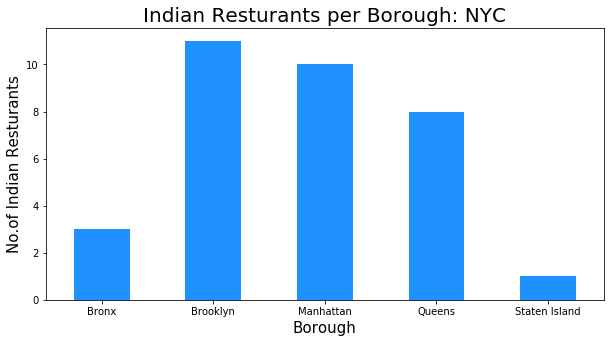

In [13]:
indian_rest_ny.groupby('Borough')['ID'].count().plot.bar(figsize=(10,5), color = clr)
plt.title('Indian Resturants per Borough: NYC', fontsize = 20)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No.of Indian Resturants', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.show()

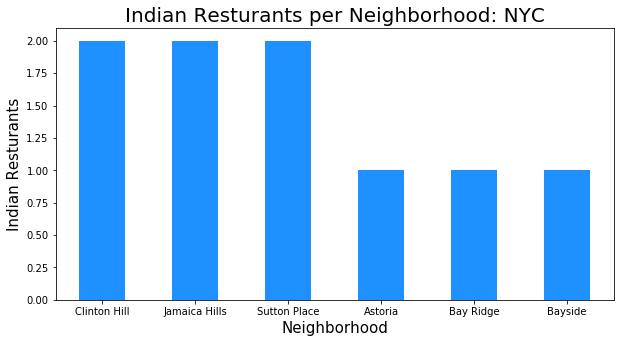

In [14]:
NOofNeigh = 6 # top number for graphing all the same past 6
indian_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(NOofNeigh).plot.bar(figsize=(10,5), color=clr)
plt.title('Indian Resturants per Neighborhood: NYC', fontsize = 20)
plt.xlabel('Neighborhood', fontsize = 15)
plt.ylabel('Indian Resturants', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.show()

In [18]:
indian_rest_ny[indian_rest_ny['Neighborhood']=='Clinton Hill']

,Borough,Neighborhood,ID,Name
9,Brooklyn,Clinton Hill,568d3902498e619efcbc3f58,Spice & Grill
10,Brooklyn,Clinton Hill,4ace7c86f964a520d3d020e3,Kinara's


In [19]:
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
indian_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1
for row in indian_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(indian_rest_ny),')','processed')
    indian_rest_stats_ny = indian_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1
indian_rest_stats_ny.tail()

{'meta': {'code': 200, 'requestId': '5ee1d9d3990f6c48e50528cb'}, 'response': {'venue': {'id': '4c0448d9310fc9b6bf1dc761', 'name': 'Curry Spot', 'contact': {'phone': '7187085900', 'formattedPhone': '(718) 708-5900'}, 'location': {'address': '4268 Katonah Ave', 'crossStreet': 'E 235 Street', 'lat': 40.897624941880906, 'lng': -73.86714729157393, 'labeledLatLngs': [{'label': 'display', 'lat': 40.897624941880906, 'lng': -73.86714729157393}, {'label': 'entrance', 'lat': 40.897709, 'lng': -73.86707}], 'postalCode': '10470', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['4268 Katonah Ave (E 235 Street)', 'Bronx, NY 10470', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/curry-spot/4c0448d9310fc9b6bf1dc761', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 

{'meta': {'code': 200, 'requestId': '5ee1d9551c2f166488cdb41b'}, 'response': {'venue': {'id': '4c194631838020a13e78e561', 'name': 'Melanies Roti Bar And Grill', 'contact': {'phone': '7184091088', 'formattedPhone': '(718) 409-1088'}, 'location': {'address': '1248 Castle Hill Ave', 'crossStreet': 'Newbold Ave', 'lat': 40.833293, 'lng': -73.85104, 'labeledLatLngs': [{'label': 'display', 'lat': 40.833293, 'lng': -73.85104}, {'label': 'entrance', 'lat': 40.833276, 'lng': -73.851166}], 'postalCode': '10462', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1248 Castle Hill Ave (Newbold Ave)', 'Bronx, NY 10462', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/melanies-roti-bar-and-grill/4c194631838020a13e78e561', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.pn

{'meta': {'code': 200, 'requestId': '5ee1d8e6867c843e1ae26172'}, 'response': {'venue': {'id': '51a5445c498ee0f182370cb2', 'name': 'Agra Taj Mahal', 'contact': {'phone': '7183892200', 'formattedPhone': '(718) 389-2200'}, 'location': {'address': '1005 Manhattan Ave', 'lat': 40.733321, 'lng': -73.954928, 'labeledLatLngs': [{'label': 'display', 'lat': 40.733321, 'lng': -73.954928}, {'label': 'entrance', 'lat': 40.73334, 'lng': -73.95492}], 'postalCode': '11222', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1005 Manhattan Ave', 'Brooklyn, NY 11222', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/agra-taj-mahal/51a5445c498ee0f182370cb2', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}], 'verified': True, 'stats': {'tipCount': 16},

{'meta': {'code': 200, 'requestId': '5ee1d897c1ce500e4edb8112'}, 'response': {'venue': {'id': '5169f5c4e4b0c7fcb77a0f3c', 'name': 'Agra Heights', 'contact': {'phone': '7184435700', 'formattedPhone': '(718) 443-5700'}, 'location': {'address': '226 Wilson Ave', 'crossStreet': 'btwn Harman & Himrod St', 'lat': 40.698094445626104, 'lng': -73.92135507234042, 'labeledLatLngs': [{'label': 'display', 'lat': 40.698094445626104, 'lng': -73.92135507234042}, {'label': 'entrance', 'lat': 40.698115, 'lng': -73.921387}], 'postalCode': '11237', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['226 Wilson Ave (btwn Harman & Himrod St)', 'Brooklyn, NY 11237', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/agra-heights/5169f5c4e4b0c7fcb77a0f3c', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/

{'meta': {'code': 200, 'requestId': '5ee1d95dba3e4d28f9f2e0f4'}, 'response': {'venue': {'id': '52f18573498ec2c34e830ffd', 'name': "Kanan's Indian Restaurant", 'contact': {'phone': '7183693777', 'formattedPhone': '(718) 369-3777'}, 'location': {'address': '452 3rd Ave', 'crossStreet': '9th Street', 'lat': 40.671890999999995, 'lng': -73.99094000000001, 'labeledLatLngs': [{'label': 'display', 'lat': 40.671890999999995, 'lng': -73.99094000000001}, {'label': 'entrance', 'lat': 40.671842, 'lng': -73.990867}], 'postalCode': '11215', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['452 3rd Ave (9th Street)', 'Brooklyn, NY 11215', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/kanans-indian-restaurant/52f18573498ec2c34e830ffd', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_

( 9 / 33 ) processed
{'meta': {'code': 200, 'requestId': '5ee1d9e108823562b28621b6'}, 'response': {'venue': {'id': '568d3902498e619efcbc3f58', 'name': 'Spice & Grill', 'contact': {}, 'location': {'address': '441 Myrtle Ave', 'crossStreet': 'Waverly', 'lat': 40.693389, 'lng': -73.968028, 'labeledLatLngs': [{'label': 'display', 'lat': 40.693389, 'lng': -73.968028}], 'postalCode': '11205', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['441 Myrtle Ave (Waverly)', 'Brooklyn, NY 11205', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/spice--grill/568d3902498e619efcbc3f58', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 6}, 'price': {'tier': 2, 'message': 'Moderate', 'currency': '$'}, 'likes

{'meta': {'code': 200, 'requestId': '5ee1d7d9af5ee91de583ccc9'}, 'response': {'venue': {'id': '543870ec498ec64de510608d', 'name': 'Masala Grill', 'contact': {}, 'location': {'address': 'Atlantic Avenue', 'crossStreet': '3rd Avenue', 'lat': 40.68554017378092, 'lng': -73.98120188318653, 'labeledLatLngs': [{'label': 'display', 'lat': 40.68554017378092, 'lng': -73.98120188318653}], 'postalCode': '11217', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['Atlantic Avenue (3rd Avenue)', 'Brooklyn, NY 11217', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/masala-grill/543870ec498ec64de510608d', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 14}, 'url': 'http://masalagrillbk.com', 'price': {'tie

{'meta': {'code': 200, 'requestId': '5ee1da93f89b1820a64fcc3a'}, 'response': {'venue': {'id': '4bb93b70cf2fc9b6fe64a002', 'name': 'Gandhi Fine Indian Cuisine', 'contact': {'phone': '7182827012', 'formattedPhone': '(718) 282-7012'}, 'location': {'address': '2032 Bedford Ave', 'crossStreet': 'btwn Clarkson Ave & Parkside Ave', 'lat': 40.65516762218564, 'lng': -73.95632450081226, 'labeledLatLngs': [{'label': 'display', 'lat': 40.65516762218564, 'lng': -73.95632450081226}], 'postalCode': '11226', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['2032 Bedford Ave (btwn Clarkson Ave & Parkside Ave)', 'Brooklyn, NY 11226', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/gandhi-fine-indian-cuisine/4bb93b70cf2fc9b6fe64a002', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 's

( 14 / 33 ) processed
{'meta': {'code': 200, 'requestId': '5ee1d9c74d8e2536ebe4ca62'}, 'response': {'venue': {'id': '4ae7876ef964a5201eac21e3', 'name': 'Kismat Indian Restaurant', 'contact': {'phone': '2127958633', 'formattedPhone': '(212) 795-8633', 'twitter': 'kismatindian'}, 'location': {'address': '603 Fort Washington Ave', 'crossStreet': '187th St', 'lat': 40.855221723964846, 'lng': -73.93696683600031, 'labeledLatLngs': [{'label': 'display', 'lat': 40.855221723964846, 'lng': -73.93696683600031}], 'postalCode': '10040', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['603 Fort Washington Ave (187th St)', 'New York, NY 10040', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/kismat-indian-restaurant/4ae7876ef964a5201eac21e3', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food

{'meta': {'code': 200, 'requestId': '5ee1d89ac1ce500e4edb86b7'}, 'response': {'venue': {'id': '529d382a11d2dd5ef107e641', 'name': 'Chapati House - NYC', 'contact': {'phone': '2127497200', 'formattedPhone': '(212) 749-7200', 'twitter': 'chapatihousenyc'}, 'location': {'address': '3153 Broadway', 'crossStreet': 'Tiemann Pl.', 'lat': 40.81457249971737, 'lng': -73.95915381671377, 'labeledLatLngs': [{'label': 'display', 'lat': 40.81457249971737, 'lng': -73.95915381671377}], 'postalCode': '10027', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['3153 Broadway (Tiemann Pl.)', 'New York, NY 10027', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/chapati-house--nyc/529d382a11d2dd5ef107e641', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}

{'meta': {'code': 200, 'requestId': '5ee1d7e0ede9ed0aeddeec0f'}, 'response': {'venue': {'id': '4b0dec08f964a520ae5223e3', 'name': 'Alachi Masala', 'contact': {'phone': '2128747420', 'formattedPhone': '(212) 874-7420', 'twitter': 'alachimasala', 'facebook': '833664873419022', 'facebookName': 'Poona Indian Restaurant'}, 'location': {'address': '488 Amsterdam Ave Frnt 1', 'lat': 40.7861663, 'lng': -73.9764143, 'labeledLatLngs': [{'label': 'display', 'lat': 40.7861663, 'lng': -73.9764143}, {'label': 'entrance', 'lat': 40.78615, 'lng': -73.976343}], 'postalCode': '10024', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['488 Amsterdam Ave Frnt 1', 'New York, NY 10024', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/alachi-masala/4b0dec08f964a520ae5223e3', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net

{'meta': {'code': 200, 'requestId': '5ee1da5a057b150fc014a734'}, 'response': {'venue': {'id': '4593ed04f964a52050401fe3', 'name': 'The Kati Roll Company', 'contact': {'phone': '2124206517', 'formattedPhone': '(212) 420-6517'}, 'location': {'address': '99 Macdougal St', 'crossStreet': 'btwn Bleecker & W 3rd St', 'lat': 40.7295697222648, 'lng': -74.00086061309852, 'labeledLatLngs': [{'label': 'display', 'lat': 40.7295697222648, 'lng': -74.00086061309852}], 'postalCode': '10012', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['99 Macdougal St (btwn Bleecker & W 3rd St)', 'New York, NY 10012', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/the-kati-roll-company/4593ed04f964a52050401fe3', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': Tr

{'meta': {'code': 200, 'requestId': '5ee1d908b1a2363762c22138'}, 'response': {'venue': {'id': '5d8d9c5e0a2ffc0008f28855', 'name': 'The Gully', 'contact': {'phone': '7188873933', 'formattedPhone': '(718) 887-3933'}, 'location': {'address': '2545 Steinway St', 'lat': 40.766719, 'lng': -73.91241, 'labeledLatLngs': [{'label': 'display', 'lat': 40.766719, 'lng': -73.91241}], 'postalCode': '11103', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['2545 Steinway St', 'New York, NY 11103', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/the-gully/5d8d9c5e0a2ffc0008f28855', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 4}, 'price': {'tier': 2, 'message': 'Moderate', 'currency': '$'}, 'likes': {'

{'meta': {'code': 200, 'requestId': '5ee1d7d0ad40e14f648bdc66'}, 'response': {'venue': {'id': '5782c9ce498edde587f5aa14', 'name': 'Tikka Indian Grill', 'contact': {'phone': '7184801307', 'formattedPhone': '(718) 480-1307'}, 'location': {'address': '119-30 Metropolitan Ave', 'lat': 40.70587364181698, 'lng': -73.83094233462995, 'labeledLatLngs': [{'label': 'display', 'lat': 40.70587364181698, 'lng': -73.83094233462995}], 'postalCode': '11415', 'cc': 'US', 'city': 'Queens', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['119-30 Metropolitan Ave', 'Queens, NY 11415', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/tikka-indian-grill/5782c9ce498edde587f5aa14', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}], 'verified': True, 'stats': {'tipCount': 2}, 'url': 'http

{'meta': {'code': 200, 'requestId': '5ee1d944dff54e5fd8561bee'}, 'response': {'venue': {'id': '4b3a8aa5f964a520996925e3', 'name': 'Sajni 026', 'contact': {'phone': '7182750606', 'formattedPhone': '(718) 275-0606'}, 'location': {'address': '9810 Queens Blvd', 'crossStreet': '65th Rd.', 'lat': 40.728123, 'lng': -73.858071, 'labeledLatLngs': [{'label': 'display', 'lat': 40.728123, 'lng': -73.858071}, {'label': 'entrance', 'lat': 40.728194, 'lng': -73.85792}], 'postalCode': '11374', 'cc': 'US', 'city': 'Rego Park', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['9810 Queens Blvd (65th Rd.)', 'Rego Park, NY 11374', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/sajni-026/4b3a8aa5f964a520996925e3', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}], 'verified': False

{'meta': {'code': 200, 'requestId': '5ee1d961ba3e4d28f9f2eb5c'}, 'response': {'venue': {'id': '4c434b2bd691c9b6ef8f8f0a', 'name': 'Sagar Restaurant', 'contact': {'phone': '7182985696', 'formattedPhone': '(718) 298-5696'}, 'location': {'address': '168-25 B Hillside Ave', 'lat': 40.710328623498505, 'lng': -73.79412262466633, 'labeledLatLngs': [{'label': 'display', 'lat': 40.710328623498505, 'lng': -73.79412262466633}], 'postalCode': '11432', 'cc': 'US', 'city': 'Jamaica', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['168-25 B Hillside Ave', 'Jamaica, NY 11432', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/sagar-restaurant/4c434b2bd691c9b6ef8f8f0a', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 6}, 'url': 'http://

{'meta': {'code': 200, 'requestId': '5ee1d962ba3e4d28f9f2ed40'}, 'response': {'venue': {'id': '4a63bfb4f964a520b3c51fe3', 'name': 'Chola Eclectic Indian Cuisine', 'contact': {'phone': '2126884619', 'formattedPhone': '(212) 688-4619', 'twitter': 'cholanyc', 'facebook': '659813484083096', 'facebookUsername': 'cholanyc', 'facebookName': 'Chola Indian Cuisine'}, 'location': {'address': '232 E 58th St', 'crossStreet': 'btw 2nd & 3rd Ave', 'lat': 40.76033870460851, 'lng': -73.96578518975763, 'labeledLatLngs': [{'label': 'display', 'lat': 40.76033870460851, 'lng': -73.96578518975763}, {'label': 'entrance', 'lat': 40.760279, 'lng': -73.965736}], 'postalCode': '10022', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['232 E 58th St (btw 2nd & 3rd Ave)', 'New York, NY 10022', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/chola-eclectic-indian-cuisine/4a63bfb4f964a520b3c51fe3', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 

{'meta': {'code': 200, 'requestId': '5ee1d93ae5ec386ad395eff6'}, 'response': {'venue': {'id': '4c48da9f3013a59356c5f0e1', 'name': 'Saffron Garden', 'contact': {'phone': '7184334449', 'formattedPhone': '(718) 433-4449'}, 'location': {'address': '46-11 Skillman Ave', 'crossStreet': 'btwn 46th and 47th', 'lat': 40.74655397129589, 'lng': -73.9177381667934, 'labeledLatLngs': [{'label': 'display', 'lat': 40.74655397129589, 'lng': -73.9177381667934}], 'postalCode': '11104', 'cc': 'US', 'city': 'Sunnyside', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['46-11 Skillman Ave (btwn 46th and 47th)', 'Sunnyside, NY 11104', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/saffron-garden/4c48da9f3013a59356c5f0e1', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}], 'verified': 

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
28,Queens,Jamaica Hills,4c434b2bd691c9b6ef8f8f0a,Sagar Restaurant,10,7.3,6
29,Queens,Jamaica Hills,0,0,0,0.0,0
30,Manhattan,Sutton Place,4a63bfb4f964a520b3c51fe3,Chola Eclectic Indian Cuisine,155,8.3,58
31,Manhattan,Sutton Place,4fe4fb50c2eee335e4fea69d,Moti Mahal Delux,186,8.5,83
32,Queens,Sunnyside Gardens,4c48da9f3013a59356c5f0e1,Saffron Garden,17,7.7,16


In [61]:
indian_rest_stats_ny.to_csv('indian_rest_stats_ny_csv.csv') # I continue to save data to a .csv as I move through this project

In [21]:
indian_rest_stats_ny.shape

(33, 7)

In [22]:
indian_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33 entries, 0 to 32
Data columns (total 7 columns):
Borough         33 non-null object
Neighborhood    33 non-null object
ID              33 non-null object
Name            33 non-null object
Likes           33 non-null object
Rating          33 non-null float64
Tips            33 non-null object
dtypes: float64(1), object(6)
memory usage: 1.9+ KB


In [23]:
indian_rest_stats_ny['Likes']=indian_rest_stats_ny['Likes'].astype('float64')
indian_rest_stats_ny['Tips']=indian_rest_stats_ny['Tips'].astype('float64')
indian_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33 entries, 0 to 32
Data columns (total 7 columns):
Borough         33 non-null object
Neighborhood    33 non-null object
ID              33 non-null object
Name            33 non-null object
Likes           33 non-null float64
Rating          33 non-null float64
Tips            33 non-null float64
dtypes: float64(3), object(4)
memory usage: 1.9+ KB


In [24]:
indian_rest_stats_ny.describe()

,Likes,Rating,Tips
count,33.000000,33.000000,33.000000
mean,67.424242,6.930303,23.909091
std,127.882766,2.371772,35.492397
min,0.000000,0.000000,0.000000
25%,10.000000,7.100000,6.000000
50%,25.000000,7.700000,14.000000
75%,62.000000,8.200000,20.000000
max,590.000000,8.800000,148.000000


In [25]:
# Resturant with maximum Likes
indian_rest_stats_ny.iloc[indian_rest_stats_ny['Likes'].idxmax()]

Borough                        Manhattan
Neighborhood                     Tribeca
ID              4bbb9dbded7776b0e1ad3e51
Name                    Tamarind TriBeCa
Likes                                590
Rating                               8.6
Tips                                 148
Name: 21, dtype: object

In [26]:
# Resturant with maximum Ratings
indian_rest_stats_ny.iloc[indian_rest_stats_ny['Rating'].idxmax()]

Borough                         Brooklyn
Neighborhood                 Fort Greene
ID              57596dad498e732300496b23
Name                         Dosa Royale
Likes                                 77
Rating                               8.8
Tips                                  22
Name: 8, dtype: object

In [27]:
# Resturant with maximum Tips
indian_rest_stats_ny.iloc[indian_rest_stats_ny['Tips'].idxmax()]

Borough                        Manhattan
Neighborhood                     Tribeca
ID              4bbb9dbded7776b0e1ad3e51
Name                    Tamarind TriBeCa
Likes                                590
Rating                               8.6
Tips                                 148
Name: 21, dtype: object

In [28]:
ny_neighborhood_stats=indian_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Neighborhood,Average Rating
7,Fort Greene,8.8
20,Prospect Lefferts Gardens,8.7
24,Tribeca,8.6
23,Sutton Place,8.4
18,North Side,8.4
17,New Dorp,8.3
10,Greenwich Village,8.2
2,Bayside,8.2
27,Washington Heights,8.0
3,Boerum Hill,8.0


In [29]:
ny_borough_stats=indian_rest_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']
ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()

,Borough,Average Rating
4,Staten Island,8.300000
2,Manhattan,8.000000
1,Brooklyn,7.445455
3,Queens,5.587500
0,Bronx,4.600000


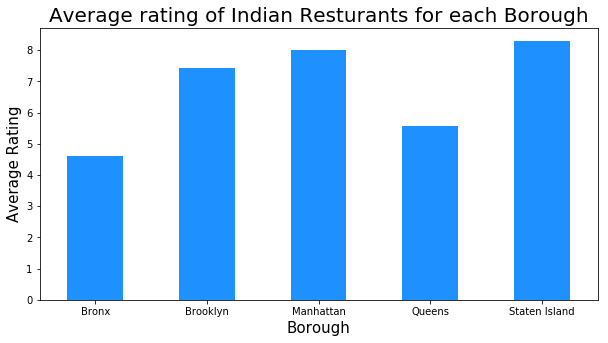

In [30]:
indian_rest_stats_ny.groupby('Borough').mean()['Rating'].plot.bar(figsize=(10,5), color=clr)
plt.title('Average rating of Indian Resturants for each Borough', fontsize=20)
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('Average Rating', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.show()

In [31]:
ny_neighborhood_stats=ny_neighborhood_stats[ny_neighborhood_stats['Average Rating']>=8.0]
ny_neighborhood_stats

,Neighborhood,Average Rating
2,Bayside,8.2
3,Boerum Hill,8.0
7,Fort Greene,8.8
10,Greenwich Village,8.2
17,New Dorp,8.3
18,North Side,8.4
20,Prospect Lefferts Gardens,8.7
23,Sutton Place,8.4
24,Tribeca,8.6
27,Washington Heights,8.0


In [32]:
ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,ny_data, on='Neighborhood')
ny_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]
ny_neighborhood_stats

,Borough,Neighborhood,Latitude,Longitude,Average Rating
0,Queens,Bayside,40.766041,-73.774274,8.2
1,Brooklyn,Boerum Hill,40.685683,-73.983748,8.0
2,Brooklyn,Fort Greene,40.688527,-73.972906,8.8
3,Manhattan,Greenwich Village,40.726933,-73.999914,8.2
4,Staten Island,New Dorp,40.572572,-74.116479,8.3
5,Brooklyn,North Side,40.714823,-73.958809,8.4
6,Brooklyn,Prospect Lefferts Gardens,40.658420,-73.954899,8.7
7,Manhattan,Sutton Place,40.760280,-73.963556,8.4
8,Manhattan,Tribeca,40.721522,-74.010683,8.6
9,Manhattan,Washington Heights,40.851903,-73.936900,8.0


In [33]:
# create map and display it
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)
# instantiate a feature group for the incidents in the dataframe
incidents = folium.map.FeatureGroup()
# loop through the 100 crimes and add each to the incidents feature group
for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

In [34]:
ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'
# add pop-up text to each marker on the map
for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# add incidents to map
ny_map.add_child(incidents)

In [35]:
!wget –quiet https://data.cityofnewyork.us/api/views/7t3b-ywvw/rows.json?accessType=DOWNLOAD -O BoroughBoundaries.geojson

--2020-06-11 07:18:07--  http://xn--quiet-xu3b/
Resolving –quiet (xn--quiet-xu3b)... failed: Name or service not known.
wget: unable to resolve host address ‘xn--quiet-xu3b’
--2020-06-11 07:18:08--  http://xn--quiet-xu3b/
Resolving –quiet (xn--quiet-xu3b)... failed: Name or service not known.
wget: unable to resolve host address ‘xn--quiet-xu3b’
--2020-06-11 07:18:08--  https://data.cityofnewyork.us/api/views/7t3b-ywvw/rows.json?accessType=DOWNLOAD
Resolving data.cityofnewyork.us (data.cityofnewyork.us)... 52.206.68.26, 52.206.140.205, 52.206.140.199
Connecting to data.cityofnewyork.us (data.cityofnewyork.us)|52.206.68.26|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/json]
Saving to: ‘BoroughBoundaries.geojson’

    [    <=>                                ] 2,883,414   4.17MB/s   in 0.7s   

2020-06-11 07:18:10 (4.17 MB/s) - ‘BoroughBoundaries.geojson’ saved [2883414]

FINISHED --2020-06-11 07:18:10--
Total wall clock time: 2.3s
Down

In [46]:
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)
ny_geo = 'BoroughBoundaries.geojson'
ny_map.choropleth(
    geo_data=ny_geo,
    data=ny_borough_stats,
    columns=['Borough', 'Average Rating'],
    key_on='feature.properties.boro_name',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Average Rating'
)
# display map
# as this is huge map data , we will save it to a file
ny_map.save('borough_rating.html')


In [56]:
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)
ny_geo = r'BoroughBoundaries.geojson'
ny_map.choropleth(
    geo_data=ny_geo,
    data=ny_borough_stats,
    columns=['Borough', 'Average Rating'],
    key_on='feature.properties.boro_name',
    fill_color='PuBu', #'YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Average Rating'
)
# display map
# as this is huge map data , we will save it to a file
ny_map.save('borough_rating.html')

### __Results / Conclusion__
1. Tribeca(Manhattan), Fort Greene(Brooklyn), and Prospect Lefferts Gardens(Brooklyn) have the best rated Indian restaurants on average.
2. Manhattan and Brooklyn have potential Indian Resturant Market
3. Staten Island ranks last in average rating of Indian Resturants.


 Despite Manhattan having the least number of neighborhoods in all five boroughs, it has the most Indian restaurants.  Based on this information, I would state that Manhattan and Brooklyn are the best locations for Indian cuisine in NYC. To have the best shot of success, I would open an Indian restaurants in Brooklyn. Brooklyn has multiple neighborhoods with average ratings exceeding 8.0 of a scale of 1.0 to 10.0 and has the least number of Indian restaurants making competition easier than in other boroughs. Finally, I would go to Tribeca in Manhattan for the best Indian food based on 148 likes. As a final note, all of the above analysis is depended  on the adequacy and accuracy of Four Square data. A more comprehensive analysis and future work would need to incorporate data from other external databases.